In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import re
import nltk
from sklearn.decomposition import PCA
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, sent_tokenize
from transformers import BertModel, BertTokenizer
import torch
import numpy as np
from bertviz import model_view, head_view

d:\01_MASTER\1 COURSE\1 semester\DATA PROCESSING\final-project-data-processing-JL-IA\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
print("GPU available:", torch.cuda.is_available())
print("GPU device name:", torch.cuda.get_device_name(0))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

GPU available: True
GPU device name: NVIDIA GeForce GTX 1060


In [ ]:
# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Iker_Al\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Iker_Al\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Iker_Al\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Iker_Al\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
df = pd.read_json("data/full_format_recipes.json")
#df = pd.DataFrame(df)
nlp = spacy.load('en_core_web_md')

In [ ]:
def process_category_text(text):
    """Process a single category text"""
    # Initialize lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    # Lemmatize
    text = lemmatizer.lemmatize(text)

    text = word_tokenize(text)

    text = [w for w in text if w not in set(stopwords.words('english'))]
    
    return text


In [ ]:
def process_category_list(text):
    """Process a list of categories with NaN handling"""
    # Handle NaN/None cases
    if isinstance(text, (float, type(None))):
        return []
    
    try:
        # Process each category in the list
        return [process_category_text(cat) for cat in text]
    except (TypeError, AttributeError):
        return []

In [ ]:
df['processed_categories'] = df['categories'].apply(process_category_list)
#df['processed_directions'] = df["directions"].apply(process_category_list)

In [ ]:
print(df[['categories', 'processed_categories']])
#print(df[['directions', 'processed_directions']])



                                              categories  \
0      [Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...   
1      [Food Processor, Onion, Pork, Bake, Bastille D...   
2      [Soup/Stew, Dairy, Potato, Vegetable, Fennel, ...   
3      [Fish, Olive, Tomato, Sauté, Low Fat, Low Cal,...   
4      [Cheese, Dairy, Pasta, Vegetable, Side, Bake, ...   
...                                                  ...   
20125  [Mixer, Cheese, Egg, Fry, Cocktail Party, Parm...   
20126  [Side, Kid-Friendly, High Fiber, Dinner, Parme...   
20127  [Onion, Poultry, turkey, Vegetable, Bake, Kid-...   
20128  [Milk/Cream, Citrus, Dairy, Fish, Garlic, Past...   
20129  [Pork, Bake, Roast, Christmas, Ham, Winter, Bo...   

                                    processed_categories  
0      [[sandwich], [bean], [fruit], [tomato], [turke...  
1      [[food, processor], [onion], [pork], [bake], [...  
2      [[soup, stew], [dairy], [potato], [vegetable],...  
3      [[fish], [olive], [tomato], [saut], 

# BERT

In [ ]:
# Process 'categories' column
def process_row(text):
    # Handle NaN, None, or non-list cases
    if not isinstance(text, list):
        return ""
    # Join list elements into a single string
    return " ".join(text)

categories_str = df["categories"].apply(process_row)

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")
model.eval()

# Tokenize the processed 'categories' column
# Convert the entire column to a single string (optional step)
combined_text = " ".join(categories_str)
input_ids = tokenizer.encode(combined_text, return_tensors="pt", max_length=512, truncation=True, return_attention_mask=True)

# Output the tokenized IDs
print(input_ids)

tensor([[  101, 11642, 14068,  5909, 20856,  4977, 15415,  4845,  1011,  5379,
          6207, 15307,  4014,  2292,  8525,  3401, 17387,  2833, 13151, 20949,
         15960,  8670,  3489, 19021, 28345,  2063,  2154,  2047,  2095,  1005,
          1055,  6574,  9550,  5909,  3417,  3467, 10720, 14753, 10439, 20624,
          2102, 11350,  1013, 20717, 11825, 14557, 15415, 21713, 11877,  2175,
          3126, 11368,  2047,  2259,  3869,  9724, 20856,  7842, 10421,  2659,
          6638,  2659, 10250,  2152, 11917,  4596,  7965, 21934,  5017, 14753,
         10439, 20624,  2102, 21877, 15782, 28897, 11825,  2489, 21443,  2489,
          3392, 17490,  2489, 25176,  2489, 12849, 19603,  8808, 11825, 24857,
         15415,  2217,  8670,  3489, 23566,  4248,  1004,  3733,  2991, 14753,
         10439, 20624,  2102,  2662, 11642,  2833, 13151, 20856,  4845,  1011,
          5379,  4248,  1004,  3733, 14732, 11611,  2621,  2292,  8525,  3401,
         14753, 10439, 20624,  2102, 16521, 14557,  

In [ ]:
# Get the embeddings
with torch.no_grad():
    outputs = model(input_ids, output_attentions=True)

# Extract the embeddings from the last hidden layer
last_hidden_states = outputs.last_hidden_state

# Get the [CLS] token embedding (first token)
cls_embedding = last_hidden_states[:, 0, :]


# Get document representations:
# 1. CLS token (document-level representation)
cls_vector = outputs.last_hidden_state[0, 0, :].numpy()

# 2. Mean of all token vectors (alternative document representation)
mean_vector = outputs.last_hidden_state[0].mean(dim=0).numpy()

# Process each document
document_vectors = []
vectors = []


cls_vector = outputs.last_hidden_state[0, 0, :].numpy()
vectors.append(cls_vector)

document_vectors.append({
    'cls_vector': cls_vector
    #, 'mean_vector': mean_vector
})

#print(input_ids)
#print(f"last_hidden_states: {last_hidden_states}")
#print(f"cls_embedding: {cls_embedding}")
#print(document_vectors)
print(cls_vector)
#print(f"input_ids['attention_mask']: {input_ids['attention_mask']}")
#print(f"input_ids: {input_ids['input_ids']}")
#print(f"tokens: {tokenizer.convert_ids_to_tokens(input_ids['input_ids'][0])}")

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


[-7.28837788e-01  1.26883715e-01 -3.41860175e-01  1.01494096e-01
 -3.91360879e-01 -2.19274208e-01  8.03299546e-02  5.99550307e-01
 -4.06167597e-01  2.76673287e-01 -2.20118403e-01 -1.82570517e-01
 -5.13631701e-02 -1.64289013e-01 -3.67959857e-01 -2.11894363e-01
  3.38765085e-01  4.45073694e-01  3.53525728e-01  5.67105353e-01
 -2.50582129e-01 -7.57691503e-01  2.49163285e-01  3.75423849e-01
  1.99021429e-01  2.57591158e-02 -1.92147911e-01 -2.99020857e-01
  3.08472842e-01 -3.81048173e-01  5.44261456e-01  4.61379915e-01
  3.65494698e-01 -4.85369742e-01  8.37634325e-01 -2.89290786e-01
  1.05567014e+00 -4.31603014e-01  4.99515921e-01  1.00994512e-01
 -1.96335055e-02  6.30460560e-01  7.40576804e-01 -4.01538759e-01
  3.12233716e-03 -3.21920775e-02 -2.85548687e+00  3.86689939e-02
 -7.41063505e-02 -6.01991117e-01  6.67684436e-01 -8.05060923e-01
  3.94453496e-01  5.74678898e-01  1.08583100e-01  4.20625925e-01
 -4.24417824e-01  4.89041537e-01  7.12999105e-01  1.56185299e-01
 -3.52446772e-02 -8.91922

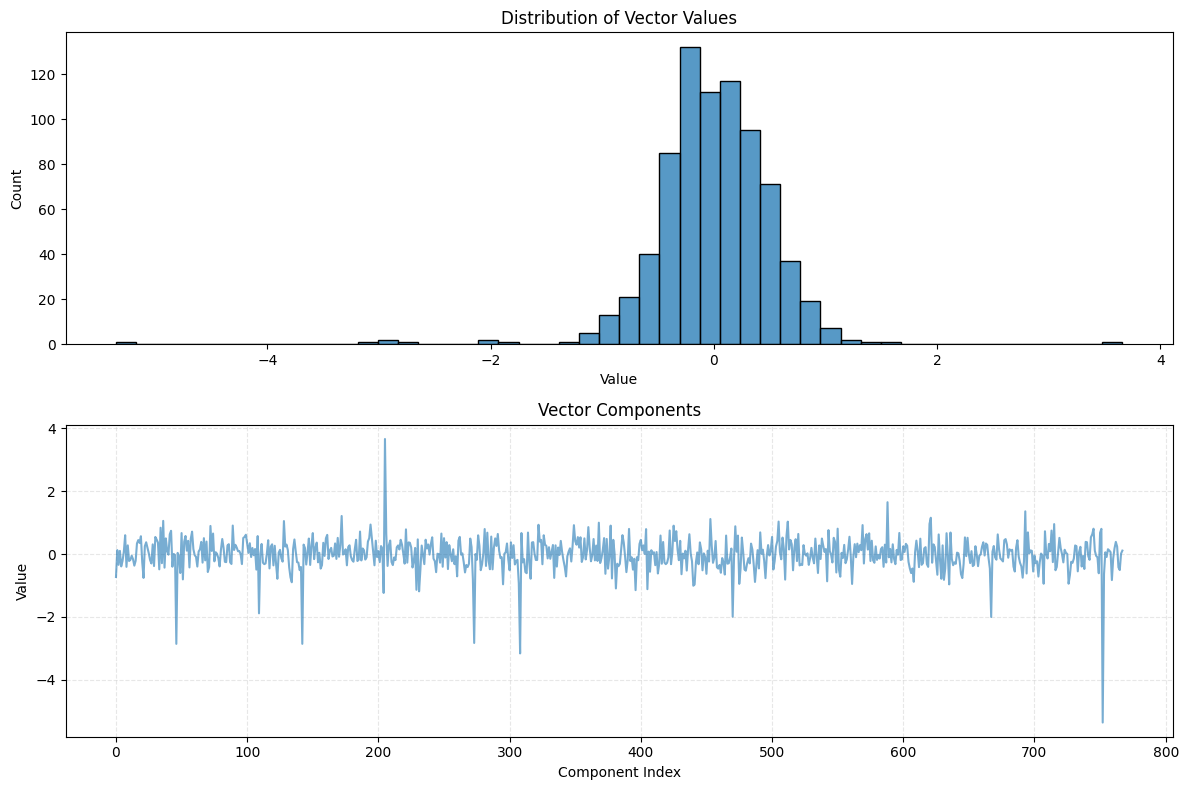

Dimensionality: 768
Mean: -0.0107
Median: 0.0053
Std Dev: 0.5437
Min: -5.3575
Max: 3.6592


In [ ]:
# Create multiple visualizations
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# 1. Distribution plot
sns.histplot(cls_vector, bins=50, ax=ax1)
ax1.set_title('Distribution of Vector Values')
ax1.set_xlabel('Value')
ax1.set_ylabel('Count')

# 2. Component values plot
ax2.plot(range(len(cls_vector)), cls_vector, '-', alpha=0.6)
ax2.set_title('Vector Components')
ax2.set_xlabel('Component Index')
ax2.set_ylabel('Value')
ax2.grid(True, linestyle='--', alpha=0.3)

# Adjust layout
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Dimensionality: {len(cls_vector)}")
print(f"Mean: {np.mean(cls_vector):.4f}")
print(f"Median: {np.median(cls_vector):.4f}")
print(f"Std Dev: {np.std(cls_vector):.4f}")
print(f"Min: {np.min(cls_vector):.4f}")
print(f"Max: {np.max(cls_vector):.4f}")

In [ ]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Move your model and tensors to GPU
#model = model.to(device)

# Get the tokens
#tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

# Plot the attention weights
#model_view(outputs.attentions, tokens)

# TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create the TF-IDF vectorizer
tfidf = TfidfVectorizer()

In [ ]:
# Convert categories into a format TF-IDF can process
docs = []
for categories in df['processed_categories']:
    if isinstance(categories, list):
        flattened = []
        for cat in categories:
            if isinstance(cat, list):
                flattened.extend(str(token) for token in cat)
            else:
                flattened.append(str(cat))
        docs.append(' '.join(flattened))

In [ ]:
# Create TF-IDF matrix
tfidf_matrix = tfidf.fit_transform(docs)

# Get feature names (words)
feature_names = tfidf.get_feature_names_out()

In [ ]:
# Convert to DataFrame for better visualization
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=feature_names
)

In [ ]:
# Print full matrix info
print("TF-IDF Matrix Shape:", tfidf_matrix.shape)
print("\nComplete TF-IDF Matrix:")
print(tfidf_df)

TF-IDF Matrix Shape: (20130, 715)

Complete TF-IDF Matrix:
          added  advance  alabama  alaska  alcoholic  almond  amaretto  \
0      0.000000      0.0      0.0     0.0        0.0     0.0       0.0   
1      0.000000      0.0      0.0     0.0        0.0     0.0       0.0   
2      0.000000      0.0      0.0     0.0        0.0     0.0       0.0   
3      0.000000      0.0      0.0     0.0        0.0     0.0       0.0   
4      0.000000      0.0      0.0     0.0        0.0     0.0       0.0   
...         ...      ...      ...     ...        ...     ...       ...   
20125  0.000000      0.0      0.0     0.0        0.0     0.0       0.0   
20126  0.000000      0.0      0.0     0.0        0.0     0.0       0.0   
20127  0.189096      0.0      0.0     0.0        0.0     0.0       0.0   
20128  0.000000      0.0      0.0     0.0        0.0     0.0       0.0   
20129  0.000000      0.0      0.0     0.0        0.0     0.0       0.0   

       anchovy  angeles  anise  ...  wok  yam      y

In [ ]:
# Show document-term statistics
print("\nTerm Statistics:")
for term in feature_names:
    non_zero_scores = tfidf_df[term][tfidf_df[term] > 0]
    if len(non_zero_scores) > 0:
        print(f"\nTerm: {term}")
        print(f"Number of documents containing term: {len(non_zero_scores)}")
        print(f"Average TF-IDF score: {non_zero_scores.mean():.4f}")
        print(f"Max TF-IDF score: {non_zero_scores.max():.4f}")


Term Statistics:

Term: added
Number of documents containing term: 3132
Average TF-IDF score: 0.1614
Max TF-IDF score: 0.2521

Term: advance
Number of documents containing term: 109
Average TF-IDF score: 0.3217
Max TF-IDF score: 0.5774

Term: alabama
Number of documents containing term: 3
Average TF-IDF score: 0.5894
Max TF-IDF score: 0.6490

Term: alaska
Number of documents containing term: 2
Average TF-IDF score: 0.5818
Max TF-IDF score: 0.6507

Term: alcoholic
Number of documents containing term: 1053
Average TF-IDF score: 0.2436
Max TF-IDF score: 0.4697

Term: almond
Number of documents containing term: 584
Average TF-IDF score: 0.3152
Max TF-IDF score: 0.7535

Term: amaretto
Number of documents containing term: 39
Average TF-IDF score: 0.4486
Max TF-IDF score: 0.5799

Term: anchovy
Number of documents containing term: 45
Average TF-IDF score: 0.4583
Max TF-IDF score: 0.8274

Term: angeles
Number of documents containing term: 21
Average TF-IDF score: 0.4183
Max TF-IDF score: 0.515

# Word2Vec

In [ ]:
# New cell
# Use the existing tokenizer from BERT to get word embeddings
#def get_avg_word_embeddings(text_list):
    # Get the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
# Tokenize and get embeddings for each document
doc_embeddings = []
    
for doc in text_list:
    if isinstance(doc, list):
        # Join all words in the document
        text = ' '.join([str(word) for sublist in doc for word in (sublist if isinstance(sublist, list) else [sublist])])
            
        # Tokenize and move to device
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}
            
        # Get embeddings using the last hidden state
        with torch.no_grad():
            outputs = model(**inputs)
            
        # Get average of all token embeddings (excluding special tokens)
        embeddings = outputs.last_hidden_state.squeeze(0)
        mask = inputs['attention_mask'].bool().squeeze(0)
        masked_embeddings = embeddings[mask]
        doc_vector = torch.mean(masked_embeddings, dim=0).cpu().numpy()
            
        doc_embeddings.append(doc_vector)
    
return np.array(doc_embeddings)

# Get document vectors
#doc_vectors = get_avg_word_embeddings(df['processed_categories'])

IndentationError: unexpected indent (2230181784.py, line 5)

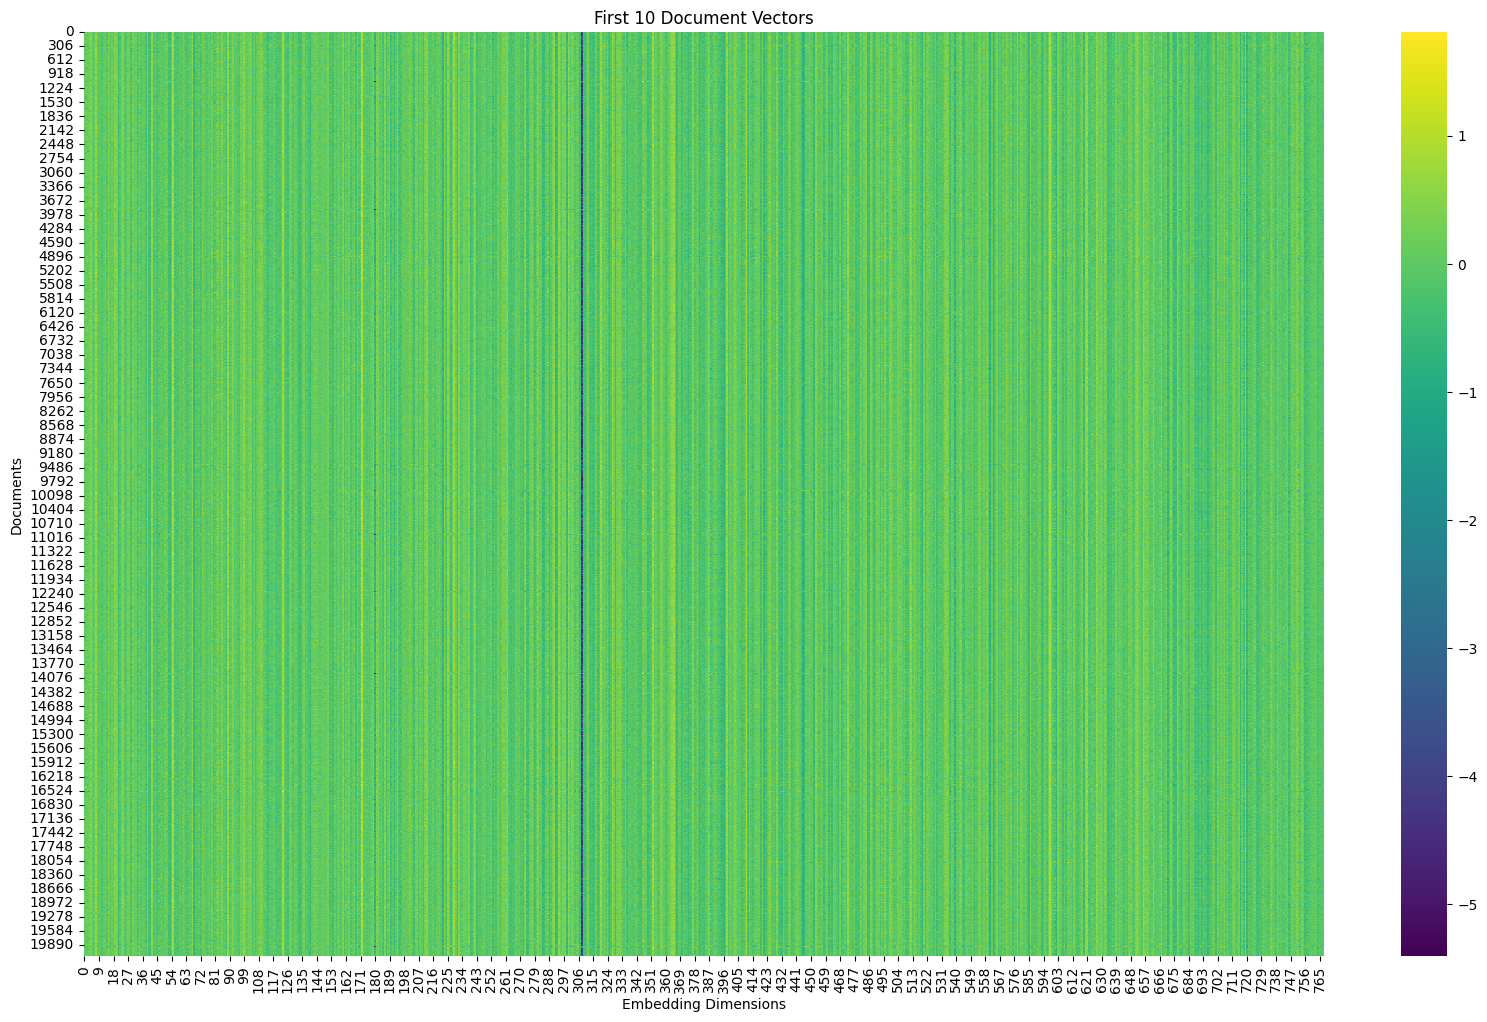

Number of documents: 20130
Vector dimension: 768

First document vector (first 10 dimensions):
[[ 0.18057068  0.32551014 -0.03888822 ...  0.06300404  0.0358379
  -0.01065802]
 [ 0.0035552   0.17747734  0.51902884 ... -0.11889039 -0.08356746
  -0.21023433]
 [ 0.24398084 -0.12992187  0.011208   ... -0.15056871 -0.20631297
   0.03131773]
 ...
 [ 0.03526636  0.19852561  0.07463191 ... -0.02672147 -0.15995088
   0.01649889]
 [ 0.10442322  0.07063877  0.32099468 ... -0.11982223 -0.18221702
  -0.15253046]
 [ 0.1936805   0.09944436  0.38450345 ... -0.03295979  0.01035101
   0.02656704]]

Basic statistics:
Mean: -0.0121
Std: 0.3332
Min: -5.4074
Max: 1.8097


In [ ]:
# New cell - Visualize the results
#import matplotlib.pyplot as plt
#import seaborn as sns

# Create visualization of document vectors
#plt.figure(figsize=(20, 12))
#sns.heatmap(doc_vectors[:10], cmap='viridis')
#sns.heatmap(doc_vectors, cmap='viridis')
#plt.title('First 10 Document Vectors')
#plt.xlabel('Embedding Dimensions')
#plt.ylabel('Documents')
#plt.show()

# Print basic statistics
#print(f"Number of documents: {len(doc_vectors)}")
#print(f"Vector dimension: {doc_vectors.shape[1]}")
#print("\nFirst document vector (first 10 dimensions):")
#print(doc_vectors[0][:10])
#print(doc_vectors)

# Basic statistics
#print("\nBasic statistics:")
#print(f"Mean: {np.mean(doc_vectors):.4f}")
#print(f"Std: {np.std(doc_vectors):.4f}")
#print(f"Min: {np.min(doc_vectors):.4f}")
#print(f"Max: {np.max(doc_vectors):.4f}")

In [ ]:
from gensim.models import Word2Vec
# Flatten the lists of lists to pass them to Word2Vec
sentences = df['processed_categories'].apply(lambda x: [item for sublist in x for item in sublist])

# Train the Word2Vec model
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4, sg=1)  # Skip-gram model

# Function to compute the document vector as the average of word embeddings
def compute_doc_vector(words, model):
    # Get vectors for words that are in the vocabulary
    vectors = [model.wv[word] for word in words if word in model.wv]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)  # Return zero vector if no words are in the vocab

# Compute document vectors for each processed_categories entry
df['doc_vector'] = sentences.apply(lambda x: compute_doc_vector(x, model))

# Show the document vectors
print(df[['processed_categories', 'doc_vector']])

                                    processed_categories  \
0      [[sandwich], [bean], [fruit], [tomato], [turke...   
1      [[food, processor], [onion], [pork], [bake], [...   
2      [[soup, stew], [dairy], [potato], [vegetable],...   
3      [[fish], [olive], [tomato], [saut], [low, fat]...   
4      [[cheese], [dairy], [pasta], [vegetable], [sid...   
...                                                  ...   
20125  [[mixer], [cheese], [egg], [fry], [cocktail, p...   
20126  [[side], [kid, friendly], [high, fiber], [dinn...   
20127  [[onion], [poultry], [turkey], [vegetable], [b...   
20128  [[milk, cream], [citrus], [dairy], [fish], [ga...   
20129  [[pork], [bake], [roast], [christmas], [ham], ...   

                                              doc_vector  
0      [0.14818297, 0.27518964, -0.09110548, -0.12065...  
1      [0.15437935, 0.15432802, -0.12442529, -0.10659...  
2      [0.17561184, 0.26615015, -0.10531669, -0.04956...  
3      [0.05315716, 0.23874995, -0.01745744

# NEURAL NETWORKS pytorch

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [ ]:
print(vectors)

[array([-7.28837788e-01,  1.26883715e-01, -3.41860175e-01,  1.01494096e-01,
       -3.91360879e-01, -2.19274208e-01,  8.03299546e-02,  5.99550307e-01,
       -4.06167597e-01,  2.76673287e-01, -2.20118403e-01, -1.82570517e-01,
       -5.13631701e-02, -1.64289013e-01, -3.67959857e-01, -2.11894363e-01,
        3.38765085e-01,  4.45073694e-01,  3.53525728e-01,  5.67105353e-01,
       -2.50582129e-01, -7.57691503e-01,  2.49163285e-01,  3.75423849e-01,
        1.99021429e-01,  2.57591158e-02, -1.92147911e-01, -2.99020857e-01,
        3.08472842e-01, -3.81048173e-01,  5.44261456e-01,  4.61379915e-01,
        3.65494698e-01, -4.85369742e-01,  8.37634325e-01, -2.89290786e-01,
        1.05567014e+00, -4.31603014e-01,  4.99515921e-01,  1.00994512e-01,
       -1.96335055e-02,  6.30460560e-01,  7.40576804e-01, -4.01538759e-01,
        3.12233716e-03, -3.21920775e-02, -2.85548687e+00,  3.86689939e-02,
       -7.41063505e-02, -6.01991117e-01,  6.67684436e-01, -8.05060923e-01,
        3.94453496e-01, 

In [ ]:
from sklearn.model_selection import train_test_split

X = vectors
Y = df["rating"].values

# Generate train and validation data, shuffle
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)

ValueError: Found input variables with inconsistent numbers of samples: [1, 20130]

In [ ]:
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm

In [ ]:

# Define the neural network with BERT embeddings as input
class RecipeRatingNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(RecipeRatingNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])  # First hidden layer
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])  # Second hidden layer
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])  # Third hidden layer
        self.output = nn.Linear(hidden_sizes[2], output_size)  # Output layer
        self.relu = nn.ReLU()  # Activation function
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.output(x)  # For regression, no activation here
        return x

# Load BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)

# Example text inputs
texts = ["Preheat oven to 350 degrees.", "Mix the ingredients until smooth."]

# Tokenize and encode the text inputs
inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=128)
inputs = {key: val.to(device) for key, val in inputs.items()}
with torch.no_grad():
    outputs = bert_model(**inputs)
    text_embeddings = outputs.last_hidden_state.mean(dim=1)  # Use mean pooling

# Combine BERT embeddings with numeric features (example)
numeric_features = torch.rand(len(texts), 6).to(device)  # Dummy numeric features
X = torch.cat((text_embeddings, numeric_features), dim=1)  # Concatenate features

# Neural network setup
input_size = X.size(1)  # Dynamic calculation of input size based on concatenated features
hidden_sizes = [512, 256, 64]  # Hidden layer sizes
output_size = 1  # Single output (rating)
model = RecipeRatingNN(input_size, hidden_sizes, output_size).to(device)

# Dummy labels (ratings)
y = torch.rand(len(texts), 1).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
for epoch in range(epochs):
    # Forward pass
    outputs = model(X)
    loss = criterion(outputs, y)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")
